# Imports

In [1]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.models import PretrainedModel, AlexNetVanilla
from utils.utils import preprocess_images, get_current_time
from utils.config import batch_size, num_epochs, model_str

# Initialize data

In [2]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

In [3]:
# Create validation set of 10% of training set
#val_inputs = init_training_inputs[-100:]
#val_outputs = training_outputs[-100:]
#init_training_inputs = init_training_inputs[:-100]
#training_outputs = training_outputs[:-100]

# Preprocessing

### Outlier detection and handling

In a normal distribution, 99.7% of the data is within +/- 3 standard deviations of the mean. We can use this to identify outliers in the data. 

Next is deciding on how to handle outliers, e.g.:

- Exclude Outliers: Exclude any voxels that are outliers in any of the images. This is a stringent approach but ensures that your model is not influenced by these extreme values.
- Exclude Outliers on a Per-Image Basis: Instead of excluding a voxel across all images, you could exclude it only for those specific images where it's an outlier. This retains more data but can complicate the modeling process.
- Winsorize Outliers: Instead of excluding outliers, you can cap them at the nearest non-outlier value (e.g., set all values above 3 to 3 and all below -3 to -3). This method reduces the impact of extreme values without losing data.
- Replace with mean: We can replace outliers with the mean of the data. This is a simple approach, but it can introduce bias into the dataset.

In [4]:
# TRAINING DATA
# Train data shape
print("(Train) Responses shape: ", training_outputs.shape)

# Total number of voxels
print("(Train) Total number of voxels: ", training_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Train) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(training_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Train) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(training_outputs) > 3) / training_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Train) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(training_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(training_outputs) > 3)[1], return_counts=True)
print("(Train) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Train) Number of times each outlier voxel is an outlier: ", outlier_counts)

# Max and min in outlier_counts
print("(Train) Max number of times an outlier voxel is an outlier: ", np.max(outlier_counts))
print("(Train) Min number of times an outlier voxel is an outlier: ", np.min(outlier_counts))

(Train) Responses shape:  (1750, 8428)
(Train) Total number of voxels:  14749000
(Train) Number of voxels outside [-3, 3] Z-score:  51365
(Train) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.348260899044003 %
(Train) Number of distinct responses with outlier voxel:  1748
(Train) Number of distinct outlier voxels:  8402
(Train) Number of times each outlier voxel is an outlier:  [6 4 8 ... 2 7 6]
(Train) Max number of times an outlier voxel is an outlier:  22
(Train) Min number of times an outlier voxel is an outlier:  1


In [5]:
# TEST DATA
# Test data shape
print("(Test) Responses shape: ", test_outputs.shape)

# Total number of voxels
print("(Test) Total number of voxels: ", test_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Test) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(test_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Test) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(test_outputs) > 3) / test_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Test) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(test_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(test_outputs) > 3)[1], return_counts=True)
print("(Test) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Test) Number of times each outlier voxel is an outlier: ", outlier_counts)

(Test) Responses shape:  (120, 8428)
(Test) Total number of voxels:  1011360
(Test) Number of voxels outside [-3, 3] Z-score:  37
(Test) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.00365844012023414 %
(Test) Number of distinct responses with outlier voxel:  21
(Test) Number of distinct outlier voxels:  27
(Test) Number of times each outlier voxel is an outlier:  [ 1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1]


### Transformations and normalization to fit PyTorch models

In [6]:
# Preprocess the images
training_inputs = preprocess_images(init_training_inputs)
test_inputs = preprocess_images(init_test_inputs)

In [7]:
# Print shapes of the preprocessed data
print("Training input shape:", training_inputs.shape)
print("Test input shape:", test_inputs.shape)

Training input shape: (1750, 3, 224, 224)
Test input shape: (120, 3, 224, 224)


### Reducing output size to number of ROI's instead of voxels

In [8]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(roi_names, np.bincount(roi)))
    roi_order = np.argsort(roi)
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1750, 7)
Example values: [-0.23860244 -0.12070409 -0.10817796 -0.14121429 -0.33175569 -0.19762734
 -0.11004769]


# Encoder model

## Model setup

In [9]:
class Encoder():
    def __init__(self, input, output, model_str):
        self.input = input
        self.output = output
        self.losses = []
        self.val_losses = []
        self.best_loss = float('inf')
        self.model_str = model_str

    def setup_model(self, batch_size):
        x_train, x_val, y_train, y_val = train_test_split(self.input, self.output, test_size=0.1)
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        x_val_tensor, y_val_tensor = torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float()

        train_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        val_data_tensor = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)

        train_dataloader = torch.utils.data.DataLoader(train_data_tensor, batch_size, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data_tensor, batch_size, shuffle=False)

        encoder_model = PretrainedModel(model_str=self.model_str)
        criterion = nn.MSELoss()

        # Freeze all layers except the classifier
        for name, param in encoder_model.named_parameters():
            if "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        optimizer = optim.Adam(encoder_model.parameters(), lr=0.0001)

        return encoder_model, criterion, optimizer, train_dataloader, val_dataloader

    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder):
        encoder.train()
        train_running_loss = 0.0

        for data in train_dataloader:
            inputs, targets = data
            optimizer.zero_grad()
            outputs = encoder(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        average_train_loss = train_running_loss / len(train_dataloader)
        return average_train_loss

    def validate(self, val_dataloader, criterion, encoder):
        encoder.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                inputs, targets = data
                outputs = encoder(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        average_val_loss = val_running_loss / len(val_dataloader)
        return average_val_loss

    def train(self, batch_size, num_epochs):
        timestamp = get_current_time()
        encoder_model, criterion, optimizer, train_dataloader, val_dataloader = self.setup_model(batch_size)

        for epoch in range(num_epochs):
            if epoch == 0:
                print(f'Training {self.model_str} for {num_epochs} epochs...')
                print(encoder_model)
            train_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model)
            val_loss = self.validate(val_dataloader, criterion, encoder_model)
            self.losses.append(train_loss)
            self.val_losses.append(val_loss)

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                best_model = encoder_model.state_dict()
                torch.save(best_model, f'../trained_models/{self.model_str}_model_{timestamp}.pth')

            print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

            if (epoch + 1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title(f'{model_str} - Encoder Loss')
                plt.plot(self.losses, label="Encoder Loss")
                plt.plot(self.val_losses, label="Encoder Validation Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Epoch")
                plt.legend()

                if epoch == num_epochs - 1:
                    save_dir = '../loss_plots/'

                    # Check if the directory exists
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)  # Create the directory if it does not exist

                    # Save plot of loss curve. Format: loss_{num_epochs}_{timestamp].png
                    plt.savefig(os.path.join(save_dir, f'{model_str}_loss_{timestamp}.png'))

                plt.show()

        return encoder_model

# Training the model

Original input data shape: (1750, 3, 224, 224)
Original outputs data shape: (1750, 8428)

Running with parameters:
     Batch size: 128
     Number of epochs: 50
     Model: AlexNet



Training AlexNet for 50 epochs...
PretrainedModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.35, inplace=False)
    (1): Linear(in_fea

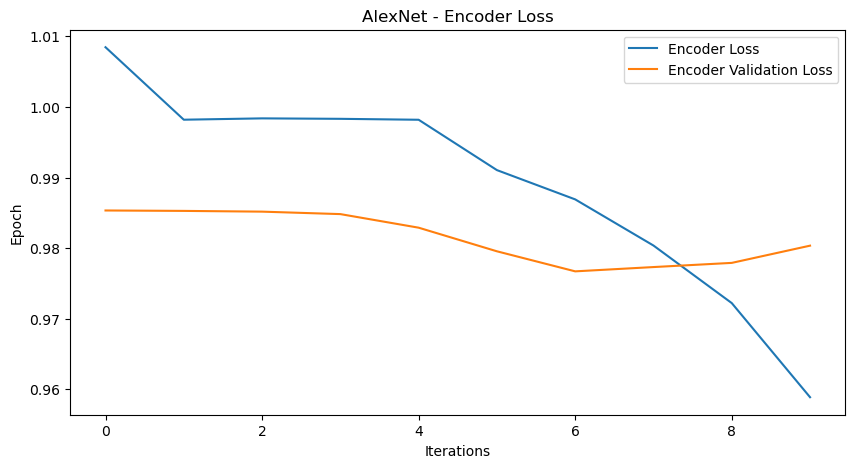

Epoch 11/50 - Training Loss: 0.9532, Validation Loss: 0.9788
Epoch 12/50 - Training Loss: 0.9425, Validation Loss: 0.9823
Epoch 13/50 - Training Loss: 0.9304, Validation Loss: 0.9798
Epoch 14/50 - Training Loss: 0.9231, Validation Loss: 0.9833
Epoch 15/50 - Training Loss: 0.9172, Validation Loss: 0.9842
Epoch 16/50 - Training Loss: 0.9060, Validation Loss: 0.9809
Epoch 17/50 - Training Loss: 0.8936, Validation Loss: 0.9823
Epoch 18/50 - Training Loss: 0.8893, Validation Loss: 0.9802
Epoch 19/50 - Training Loss: 0.8768, Validation Loss: 0.9815
Epoch 20/50 - Training Loss: 0.8706, Validation Loss: 0.9809


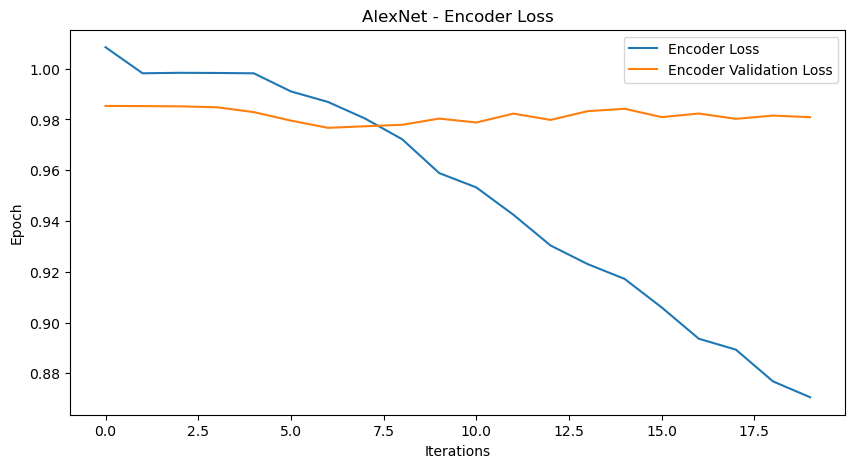

Epoch 21/50 - Training Loss: 0.8608, Validation Loss: 0.9811
Epoch 22/50 - Training Loss: 0.8545, Validation Loss: 0.9785
Epoch 23/50 - Training Loss: 0.8443, Validation Loss: 0.9828
Epoch 24/50 - Training Loss: 0.8320, Validation Loss: 0.9805


KeyboardInterrupt: 

In [10]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)
print('')
print('Running with parameters:')
print('     Batch size:', batch_size)
print('     Number of epochs:', num_epochs)
print('     Model:', model_str)
print('')

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs, model_str)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)